In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.datasets.emnist_lines_dataset import EmnistLinesDataset

In [12]:
dataset = EmnistLinesDataset(max_length=8, min_overlap=0, max_overlap=0, num_train=100000, num_test=10000)
dataset.load_or_generate_data()
print(dataset)
print(dataset.x_train.shape, dataset.y_train.shape)
print(dataset.x_test.shape, dataset.y_test.shape)

EmnistLinesDataset loading data from HDF5...
EMNIST Lines Dataset
Max length: 8
Min overlap: 0
Max overlap: 0
Num classes: 80
Input shape: (28, 224)
Train: (100000, 28, 224) (100000, 8, 80)
Test: (10000, 28, 224) (10000, 8, 80)

(100000, 28, 224) (100000, 8, 80)
(10000, 28, 224) (10000, 8, 80)


## TimeDistributed

In [13]:
from text_recognizer.networks.lenet import lenet

lenet_network = lenet(input_shape=(28, 28), output_shape=(80, 1))

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Permute, TimeDistributed
from tensorflow.keras.models import Model, Sequential

network = Sequential()
network.add(Input(shape=(28, 224)))          # Take the whole line as input
network.add(Reshape((28, 8, 28)))            # Reshape it to make 8 character-sized inputs
network.add(Permute((2, 1, 3)))              # Allow indexing through characters first
network.add(TimeDistributed(lenet_network))  # Apply the lenet_network to each character
network.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 8, 28)         0         
_________________________________________________________________
permute_3 (Permute)          (None, 8, 28, 28)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 80)             1208912   
Total params: 1,208,912
Trainable params: 1,208,912
Non-trainable params: 0
_________________________________________________________________


In [14]:
network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics='accuracy')
network.fit(
    x=dataset.x_train,
    y=dataset.y_train,
    batch_size=64,
    epochs=5,
    validation_data=(dataset.x_test, dataset.y_test)
)

Epoch 1/5
1563/1563 [==============================] - 39s 25ms/step - loss: 0.6769 - accuracy: 0.8787 - val_loss: 0.3114 - val_accuracy: 0.9249
Epoch 2/5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3310 - accuracy: 0.9199 - val_loss: 0.2643 - val_accuracy: 0.9336
Epoch 3/5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.2863 - accuracy: 0.9293 - val_loss: 0.2505 - val_accuracy: 0.9369
Epoch 4/5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.2618 - accuracy: 0.9344 - val_loss: 0.2389 - val_accuracy: 0.9383
Epoch 5/5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.2450 - accuracy: 0.9379 - val_loss: 0.2287 - val_accuracy: 0.9408


## All-convolutional network

In [15]:
from text_recognizer.networks import line_cnn_all_conv

network = line_cnn_all_conv(input_shape=(28, 224), output_shape=(8, 80), window_width=28, window_stride=28)
network.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 224, 1)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 224, 32)       320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 224, 64)       18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 112, 64)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 112, 64)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 8, 128)         1605760   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 8, 128)        

In [16]:
network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics='accuracy')
network.fit(
    x=dataset.x_train,
    y=dataset.y_train,
    batch_size=64,
    epochs=5,
    validation_data=(dataset.x_test, dataset.y_test)
)

Epoch 1/5
1563/1563 [==============================] - 24s 16ms/step - loss: 0.5764 - accuracy: 0.9000 - val_loss: 0.2759 - val_accuracy: 0.9319
Epoch 2/5
1563/1563 [==============================] - 24s 16ms/step - loss: 0.2783 - accuracy: 0.9325 - val_loss: 0.2434 - val_accuracy: 0.9390
Epoch 3/5
1563/1563 [==============================] - 24s 16ms/step - loss: 0.2427 - accuracy: 0.9395 - val_loss: 0.2308 - val_accuracy: 0.9414
Epoch 4/5
1563/1563 [==============================] - 24s 16ms/step - loss: 0.2212 - accuracy: 0.9443 - val_loss: 0.2232 - val_accuracy: 0.9432
Epoch 5/5
1563/1563 [==============================] - 24s 16ms/step - loss: 0.2070 - accuracy: 0.9475 - val_loss: 0.2169 - val_accuracy: 0.9445


## Adding overlap between characters

In [8]:
dataset_with_overlap = EmnistLinesDataset(max_length=8, min_overlap=0.5, max_overlap=0.5, num_train=100000, num_test=10000)
dataset_with_overlap.load_or_generate_data()
print(dataset_with_overlap)
print(dataset_with_overlap.x_train.shape, dataset_with_overlap.y_train.shape)
print(dataset_with_overlap.x_test.shape, dataset_with_overlap.y_test.shape)

EmnistLinesDataset loading data from HDF5...
EMNIST Lines Dataset
Max length: 8
Min overlap: 0.5
Max overlap: 0.5
Num classes: 80
Input shape: (28, 224)
Train: (100000, 28, 224) (100000, 8, 80)
Test: (10000, 28, 224) (10000, 8, 80)

(100000, 28, 224) (100000, 8, 80)
(10000, 28, 224) (10000, 8, 80)


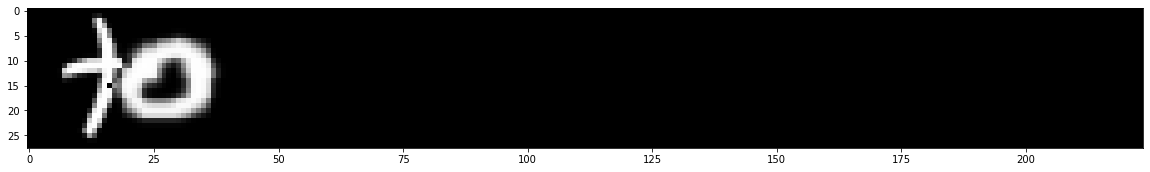

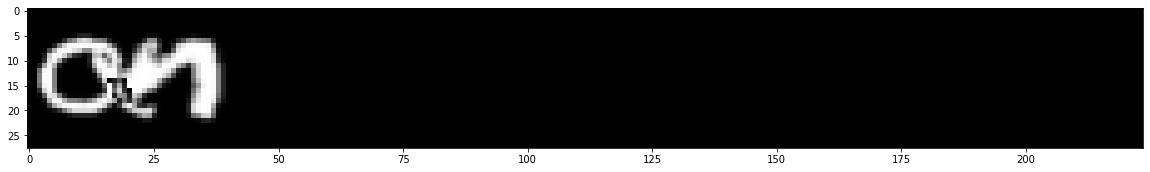

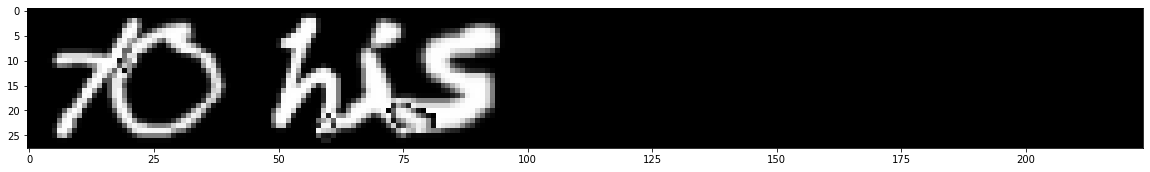

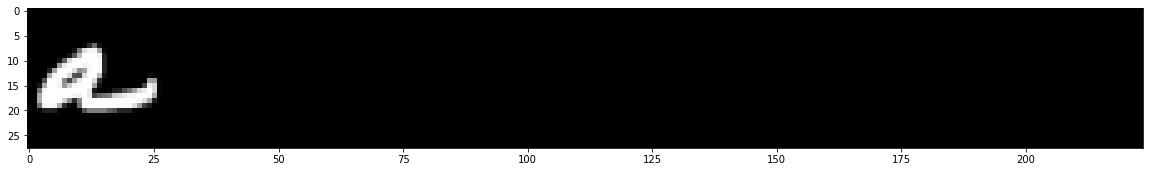

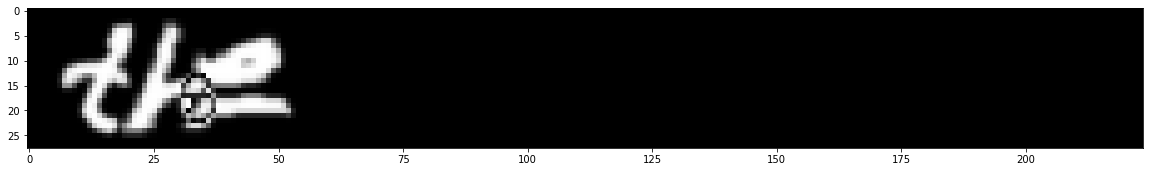

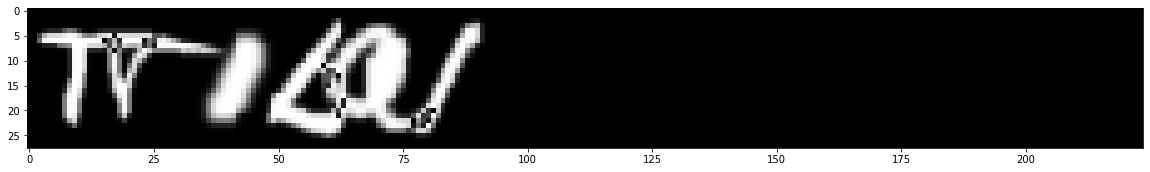

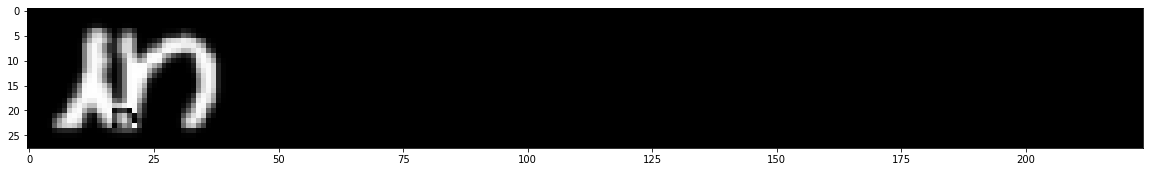

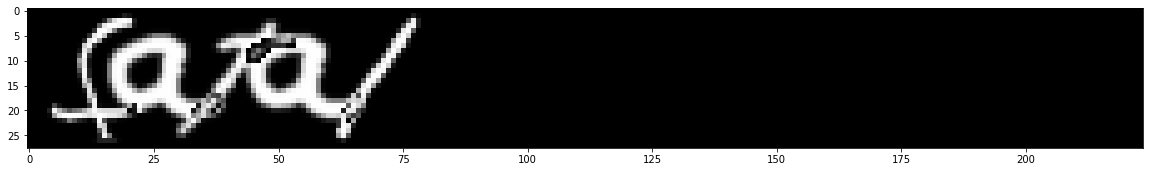

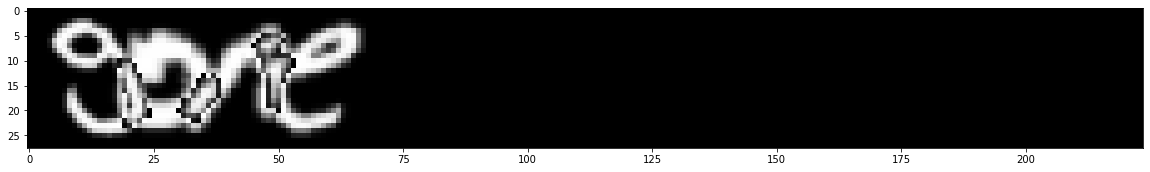

In [9]:
num_samples_to_plot = 9

for i in range(num_samples_to_plot):
    plt.figure(figsize=(20, 20))
    plt.imshow(dataset_with_overlap.x_train[i], cmap='gray')

In [10]:
# Since we're overlapping by half, let's reduce our stride by half, so that we see a window centered on each character
network = line_cnn_all_conv(input_shape=(28, 224), output_shape=(8, 80), window_width=28, window_stride=14)
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 224, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 224, 32)       320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 224, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 112, 64)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 112, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 16, 128)        1605760   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 16, 128)       

In [11]:
network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics='accuracy')
network.fit(
    x=dataset_with_overlap.x_train,
    y=dataset_with_overlap.y_train,
    batch_size=64,
    epochs=5,
    validation_data=(dataset_with_overlap.x_test, dataset_with_overlap.y_test)
)

Epoch 1/5
1563/1563 [==============================] - 35s 22ms/step - loss: 1.7346 - accuracy: 0.6406 - val_loss: 1.3674 - val_accuracy: 0.6853
Epoch 2/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.3987 - accuracy: 0.6783 - val_loss: 1.3183 - val_accuracy: 0.6944
Epoch 3/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.3461 - accuracy: 0.6889 - val_loss: 1.2847 - val_accuracy: 0.7015
Epoch 4/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.3145 - accuracy: 0.6953 - val_loss: 1.2624 - val_accuracy: 0.7055
Epoch 5/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.2927 - accuracy: 0.6998 - val_loss: 1.2564 - val_accuracy: 0.7084
